# DLPFC single gene trajectory example

Compare vs single gene from belayer paper on DLPFC (sample 151673? gene NEFH?)

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import to_rgba
from matplotlib import colormaps
from matplotlib.patches import Circle, Patch
from matplotlib.lines import Line2D
from scipy.stats import spearmanr

%matplotlib inline

sys.path.append('/mnt/data1/spatial/tissue-alignment/traversal')
from io_utils import read_image, read_spatial_data, read_transcription_data, read_embedding_data
from plot import draw_start, draw_path, draw_clusters
from graph import compute_distance_matrix, compute_path_idxs, compute_clusters, compute_path_counts

In [2]:
model = 'triplet-dlpfc-0999'
fullres = False

section_path = '/mnt/data1/spatial/data/dlpfc/donor3/151673'
im = read_image(section_path, fullres)

pos_df, spot_radius = read_spatial_data(section_path, fullres)

embeds = read_embedding_data(section_path, model)

start_idx = 347
end_idx = 3547

dists, hex_adj = compute_distance_matrix(embeds, pos_df)
path_idxs = compute_path_idxs(dists, hex_adj, start_idx, end_idx)
clusters = compute_clusters(embeds, embeds[path_idxs])
counts = read_transcription_data(section_path)

atat_counts, _ = compute_path_counts(pos_df, counts, path_idxs, clusters)

QUEUEING TASKS | :   0%|          | 0/83 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/83 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/83 [00:00<?, ?it/s]

In [3]:
sys.path.append('/mnt/data1/spatial/belayer/src')
from utils_IO import *

from harmonic import *
from region_cost_fun import *
from dprelated import *
from dp_post_processing import *
from general_helper_funcs import *
from precompute_likelihood import *
from dp_linear_boundary import *
from slideseq_helpers import *

# input_10x_folder='151673'
_, coords, barcodes, gene_labels = read_input_10xdirectory(section_path)

# fill in gaps in 10x hexagonal grid
fullpoints, in_tissue = fill_geometry(coords, is_hexagon=True)

# get boundary points
boundary_idx_file='dlpfc-donor3-151673-boundaries.npy'
bounds = np.load(boundary_idx_file, allow_pickle=True)
new_bounds = []
for b in bounds:
    new_bounds.append(pos_df.loc[b, ['row', 'col']].to_numpy())
new_bounds = np.asarray(new_bounds, dtype=object)
boundary_file = 'dlpfc-donor3-151673-boundaries-coords.npy'
np.save(boundary_file, new_bounds)
boundary_list = read_boundary_list(boundary_file, fullpoints)

spos = spatialcoord(x = fullpoints[:,0], y = fullpoints[:,1])
har = harmonic(fullpoints, spos.adjacency_mat, np.sqrt(spos.pairwise_squared_dist))

interpolation = har.interpolation_using_list( boundary_list )
depth = interpolation[in_tissue]

pos_df.loc[pos_df['barcode'].argsort(), 'depth'] = depth

pos_df['depth2'] = pos_df['depth'].round().astype(int)
pos_df['depth2'] = pos_df['depth2'] - pos_df['depth2'].min() # make min 0

In [4]:
assert not (pos_df['depth2'].value_counts() == 0).any()

In [5]:
dummy_path_idxs = [-1] * (pos_df['depth2'].max() + 1) # assumes there are no gaps in depth2, see prior assert
belayer_counts, _ = compute_path_counts(
    pos_df=pos_df,
    counts=counts,
    path_idxs=dummy_path_idxs,
    clusters=pos_df['depth2'],
)

QUEUEING TASKS | :   0%|          | 0/166 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/166 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/166 [00:00<?, ?it/s]

In [6]:
normalized_length = 101

def length_normalize_counts(df):
    xp = np.linspace(0, 1, len(df))
    x = np.linspace(0, 1, normalized_length)
    out = []
    for i in range(df.shape[1]):
        interp = np.interp(x, xp, df.iloc[:, i].to_numpy())
        out.append(interp)
    path_normalized_counts = pd.DataFrame(np.asarray(out).T, columns=df.columns)
    return path_normalized_counts

atat_path_normalized_counts = length_normalize_counts(atat_counts)
belayer_path_normalized_counts = length_normalize_counts(belayer_counts)

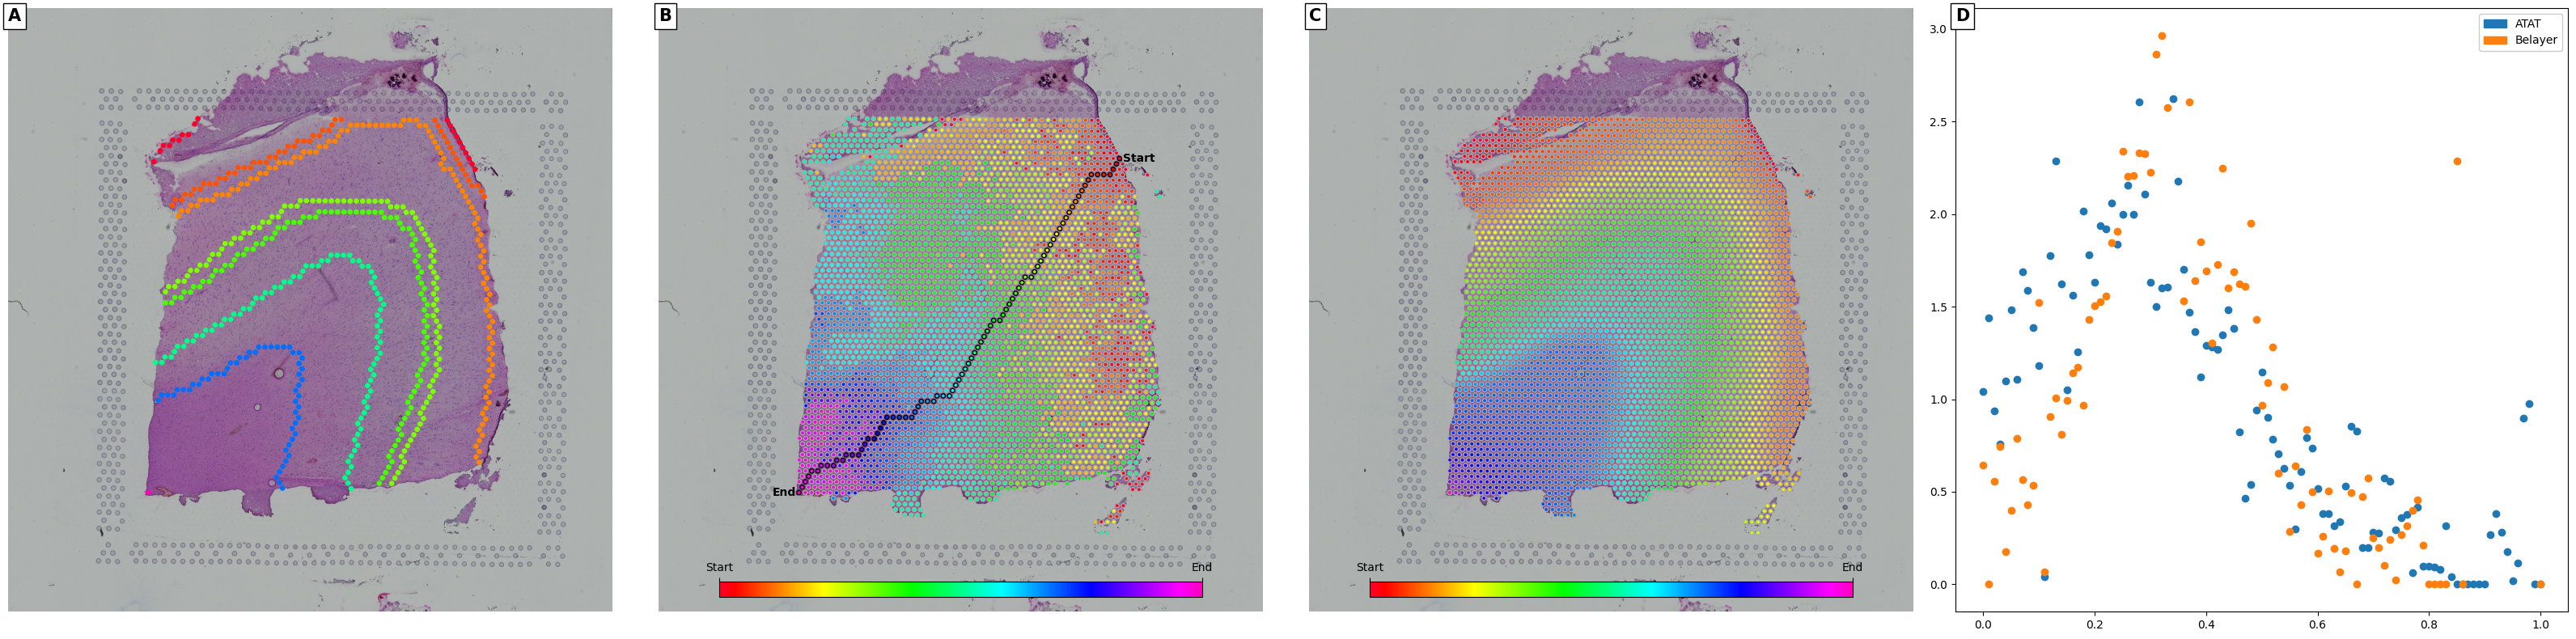

In [14]:
figsize = 8
fontsize = 15
nrows = 1
ncols = 4

plt.close()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows, ncols, figsize=(figsize*ncols, figsize*nrows))

ax1.imshow(im)
ax2.imshow(im)
ax3.imshow(im)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

cm_name = 'gist_rainbow'
cmap = colormaps[cm_name]
cmap_interp = np.linspace(0, 1, pos_df['depth2'].max() + 1)

for b in bounds:
    bound_coords = pos_df.loc[b, ['x', 'y']].sort_values('y').to_numpy()
    avg_bound_depth = int(round(pos_df.loc[b, 'depth2'].mean()))
    color = cmap(cmap_interp[avg_bound_depth])
    for x, y in bound_coords:
        circ = Circle((x, y), spot_radius, color=color)
        ax1.add_artist(circ)

def draw_spots(ax, spot_radius, pos_df):
    circs = PatchCollection(
        [Circle((x, y), spot_radius) for x, y in pos_df[["x", "y"]].to_numpy()],
        picker=True,
    )
    facecolors = np.asarray([list(to_rgba("lightgray"))] * len(pos_df))
    edgecolors = np.asarray([list(to_rgba("darkgray"))] * len(pos_df))
    alphas = np.full(len(pos_df), 1)
    circs.set_facecolor(facecolors)
    circs.set_edgecolor(edgecolors)
    circs.set_alpha(alphas)
    ax.add_collection(circs)
    return circs, facecolors, edgecolors, alphas

circs, facecolors, edgecolors, alphas = draw_spots(ax2, spot_radius, pos_df)
circs2, facecolors2, edgecolors2, alphas2 = draw_spots(ax3, spot_radius, pos_df)

xs = np.linspace(0, 1, normalized_length)
legend_elements = [
    Patch(color='tab:blue', label='ATAT'),
    Patch(color='tab:orange', label='Belayer'),
]
for gene, marker in zip(['NEFH'], ["o"]):
    ax4.scatter(xs, atat_path_normalized_counts[gene], color='tab:blue', marker=marker)
    ax4.scatter(xs, belayer_path_normalized_counts[gene], color='tab:orange', marker=marker)
    # legend_elements.append(Line2D([0], [0], marker=marker, ls="", color='black', label=gene))

    rho, p_val = spearmanr(
        atat_path_normalized_counts[gene],
        belayer_path_normalized_counts[gene],
    )

ax4.legend(handles=legend_elements, loc='upper right', framealpha=1)

fig.tight_layout()

draw_start(ax2, pos_df, start_idx, 'right', circs, edgecolors)
draw_path(ax2, pos_df, path_idxs, 'left', circs, edgecolors)
draw_clusters(fig, ax2, path_idxs, clusters, circs, facecolors, show_cbar=True)

draw_clusters(
    fig=fig,
    ax=ax3,
    path_idxs=dummy_path_idxs,
    clusters=pos_df['depth2'],
    circs=circs2,
    facecolors=facecolors2,
    # edgecolors=edgecolors,
    cm_name=cm_name,
)

ax1_bbox = ax1.get_position()
ax2_bbox = ax2.get_position()
ax3_bbox = ax3.get_position()
ax4_bbox = ax4.get_position()

fig.text(ax1_bbox.xmin, ax1_bbox.ymax, 'A', ha='left', va='top', fontsize=fontsize, weight='bold', bbox={'facecolor':'white', 'edgecolor':'black'})
fig.text(ax2_bbox.xmin, ax2_bbox.ymax, 'B', ha='left', va='top', fontsize=fontsize, weight='bold', bbox={'facecolor':'white', 'edgecolor':'black'})
fig.text(ax3_bbox.xmin, ax3_bbox.ymax, 'C', ha='left', va='top', fontsize=fontsize, weight='bold', bbox={'facecolor':'white', 'edgecolor':'black'})
fig.text(ax4_bbox.xmin, ax4_bbox.ymax, 'D', ha='left', va='top', fontsize=fontsize, weight='bold', bbox={'facecolor':'white', 'edgecolor':'black'})

fig.savefig('fig8.png')